In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import spacy

import ssl
import socket

In [2]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)

In [3]:
mails = pd.read_csv('merged_datasets.csv')
categories = pd.CategoricalDtype(['safe', 'phishing'], ordered=True)
mails['label'] = mails['label'].astype(categories)

In [4]:
mails.drop_duplicates(subset=['subject', 'sender_mail'],
                      keep='first',
                      inplace=True)


mails.dropna(subset=['body', 'sender_mail'], inplace=True)

In [5]:
# # Shufflujemy sobie
# mails = mails.sample(frac=1).reset_index(drop=True)

# # Na potrzeby obliczeń zmniejszamy
# cut_rows_to = 25000
# mails = mails.iloc[:cut_rows_to, :]
# print(mails.phishing.value_counts())

In [6]:
def extract_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    matches = re.findall(url_pattern, text)

    return matches, len(matches)

mails[['extracted_urls', 'urls_count']] = mails['body'].apply(lambda x:
                                                              pd.Series(extract_urls(x)))


def map_url_lens(lens):
    if lens <= 2:
        return str(lens)
    else:
        return '3<='

mails['urls_count'] = mails['urls_count'].apply(map_url_lens)
categories = pd.CategoricalDtype(['0', '1', '2', '3<='], ordered=True)
mails['urls_count'] = mails['urls_count'].astype(categories)

In [7]:
# Jeżeli jeden url w mailu jest fałszywy, to wychodzimy z założenia, że inne też
def return_random_url(urls):
    urls_len = len(urls)
    if urls_len == 0:
        return None
    

    random_index = np.random.randint(0, urls_len)
    randomized_url = urls[random_index]
    return randomized_url

mails['in_body_url'] = mails['extracted_urls'].apply(return_random_url)

In [8]:
def is_https(url):
    if url is None:
        return 'None'

    protocol = url[:5].lower()
    return 'https' if protocol == 'https' else 'http'


mails['protocol'] = mails['in_body_url'].apply(is_https)
categories = pd.CategoricalDtype(['None', 'http', 'https'], ordered=True)
mails['protocol'] = mails['protocol'].astype(categories)
legit_rows = mails[mails['label'] == 'safe']
print(legit_rows['protocol'].value_counts(normalize=True, dropna=False))

protocol
None     0.623623
http     0.354257
https    0.022119
Name: proportion, dtype: float64


In [9]:
def get_domain(url):
    if url is None:
        return 'no url'

    # Get domain out of url
    pattern = re.compile(r'https?://([^/]+)')
    match = pattern.match(url)
    
    if match:
        domain = match.group(1)
        return domain
    else:
        return 'url error'


mails['domain_(in_body_url)'] = mails['in_body_url'].apply(get_domain)

In [10]:
def get_subdomain_level(domain):
    if domain is None:
        return -1
    return domain.count('.')-1


def map_subdomain_lv(num):
    if num == -1:
        return 'None'
    if num <= 5:
        return str(num)
    else:
        return '6<='



mails['subdomain_level'] = mails['domain_(in_body_url)'].apply(get_subdomain_level)
mails['subdomain_level'] = mails['subdomain_level'].apply(map_subdomain_lv)
categories = pd.CategoricalDtype(['None', '0', '1', '2', '3<='], ordered=True)
mails['subdomain_level'] = mails['subdomain_level'].astype(categories)


print(mails['subdomain_level'].value_counts(normalize=True))

subdomain_level
None    0.553776
1       0.276854
0       0.126435
2       0.042936
3<=     0.000000
Name: proportion, dtype: float64


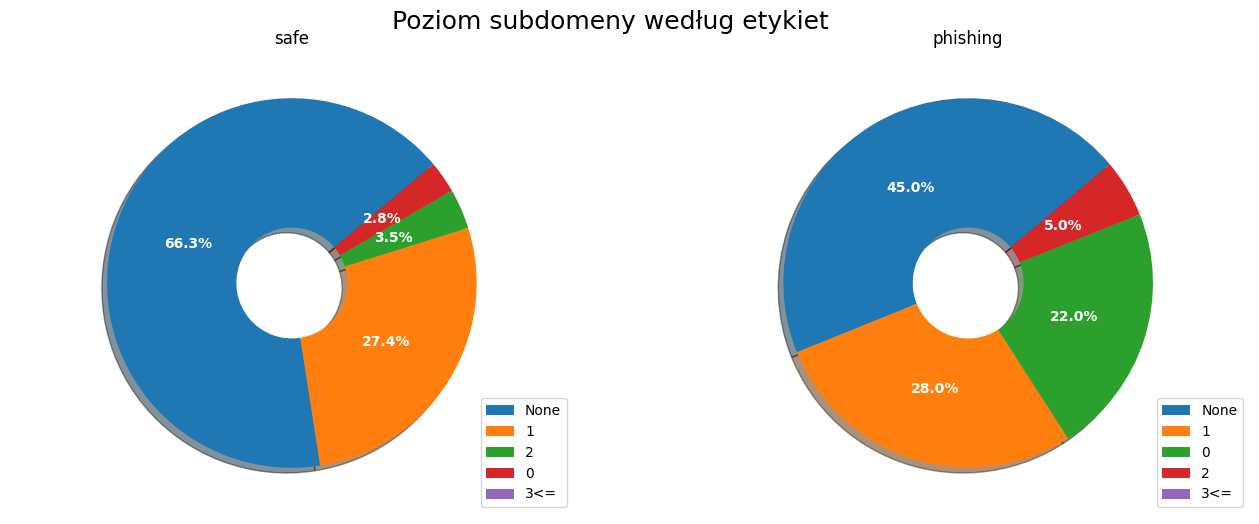

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# SAFE
legit_rows = mails[mails['label']=='safe']
dots_data = legit_rows['subdomain_level'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[0].axis('equal')
ax[0].set_title('safe')

wedges, texts, autotexts = ax[0].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[0].legend(wedges, labels, loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

# PHISHING
phishing_rows = mails[mails['label']=='phishing']
dots_data = phishing_rows['subdomain_level'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[1].axis('equal')
ax[1].set_title('phishing')

wedges, texts, autotexts = ax[1].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[1].legend(wedges, labels, loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

plt.suptitle('Poziom subdomeny według etykiet', fontsize=18, y=0.95)
plt.show()

In [12]:
print(mails.info(), end='\n\n')
print(mails['label'].value_counts(normalize=True), end='\n\n')
print(mails['protocol'].value_counts(normalize=True, dropna=False), end='\n\n')
print(mails['urls_count'].value_counts(normalize=True, dropna=False), end='\n\n')


<class 'pandas.core.frame.DataFrame'>
Index: 87633 entries, 0 to 99469
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Unnamed: 0            87633 non-null  int64   
 1   sender_mail           87633 non-null  object  
 2   subject               87633 non-null  object  
 3   body                  87633 non-null  object  
 4   label                 87633 non-null  category
 5   extracted_urls        87633 non-null  object  
 6   urls_count            87633 non-null  category
 7   in_body_url           41716 non-null  object  
 8   protocol              87633 non-null  category
 9   domain_(in_body_url)  87633 non-null  object  
 10  subdomain_level       87223 non-null  category
dtypes: category(4), int64(1), object(6)
memory usage: 5.7+ MB
None

label
phishing    0.512992
safe        0.487008
Name: proportion, dtype: float64

protocol
None     0.523969
http     0.462919
https    0.013111
Name: 

In [13]:
mails.drop(mails.columns[0], axis=1, inplace=True)
print(mails.head(5))

                               sender_mail  \
0                          Young@iworld.de   
1                   ipline's1983@icable.ph   
2  Karmandeep-opengevl@universalnet.psi.br   
3                        ivqrnai@pobox.com   
4         externalsep1@loanofficertool.com   

                                                                                                                                                  subject  \
0                                                                                                                               Never agree to be a loser   
1                                                                                                                                  Befriend Jenna Jameson   
2                                                                                                                                    CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/trunk: lib/Mail/SpamAssassin/PerMsgStatus.pm lib/

In [14]:
def count_slashes(url):
    if url is None:
        return -1
    
    return url.count('/')


def map_slashes(num):
    if num == -1:
        return str(0)
    if num <= 5:
        return str(num)
    else:
        return '6<='



mails['slash_count'] = mails['in_body_url'].apply(count_slashes)

mails['slash_count'] = mails['slash_count'].apply(map_slashes)
categories = pd.CategoricalDtype(['0', '1', '2', '3', '4', '5', '6<='], ordered=True)
mails['slash_count'] = mails['slash_count'].astype(categories)

In [15]:
def count_dots(url):
    if url is None:
        return -1
    
    return url.count('.')


def map_dots(num):
    if num == -1:
        return str(0)
    if num <= 4:
        return str(num)
    else:
        return '5<='


mails['dots_count'] = mails['in_body_url'].apply(count_dots)

mails['dots_count'] = mails['dots_count'].apply(map_dots)
categories = pd.CategoricalDtype(['0', '1', '2', '3', '4', '5<='], ordered=True)
mails['dots_count'] = mails['dots_count'].astype(categories)

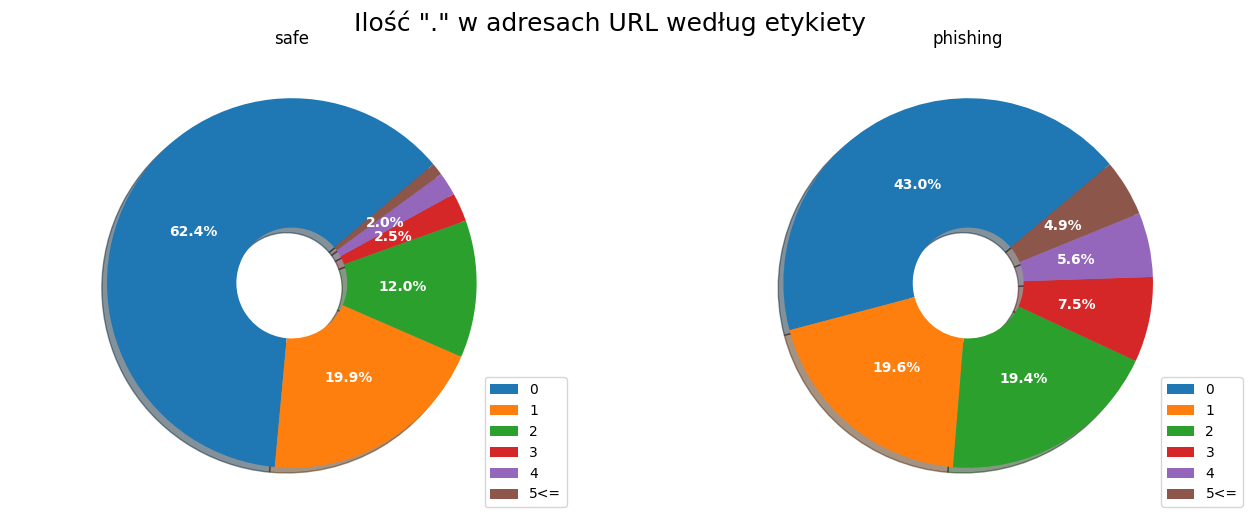

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# SAFE
legit_rows = mails[mails['label']=='safe']
dots_data = legit_rows['dots_count'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[0].axis('equal')
ax[0].set_title('safe')

wedges, texts, autotexts = ax[0].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[0].legend(wedges, sorted(labels), loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

# PHISHING
phishing_rows = mails[mails['label']=='phishing']
dots_data = phishing_rows['dots_count'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[1].axis('equal')
ax[1].set_title('phishing')

wedges, texts, autotexts = ax[1].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[1].legend(wedges, sorted(labels), loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

plt.suptitle('Ilość "." w adresach URL według etykiety', fontsize=18, y=0.95)
plt.show()

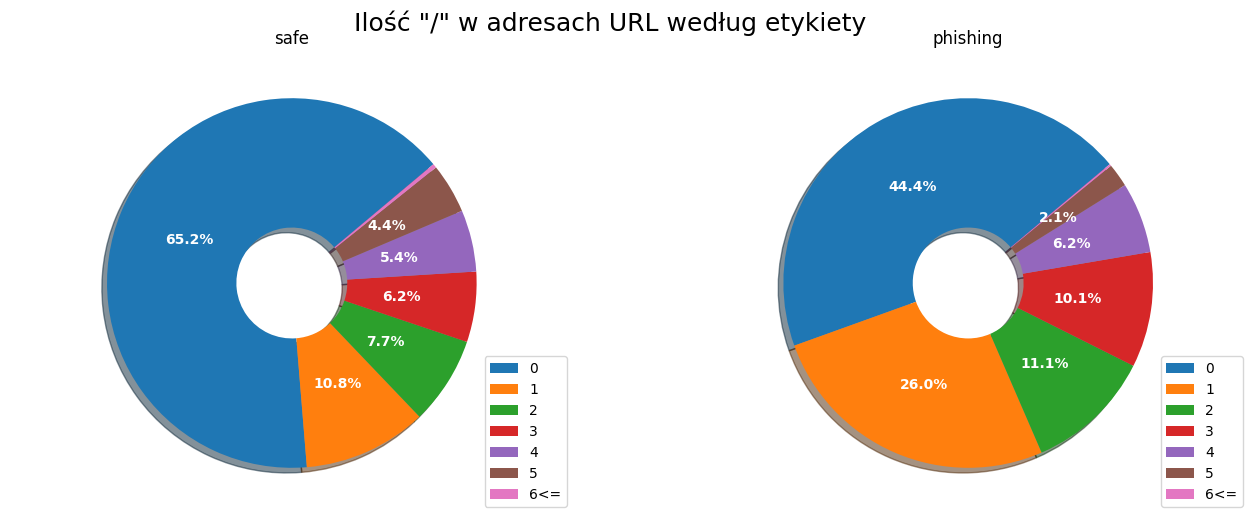

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# SAFE
legit_rows = mails[mails['label']=='safe']
dots_data = legit_rows['slash_count'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[0].axis('equal')
ax[0].set_title('safe')

wedges, texts, autotexts = ax[0].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[0].legend(wedges, sorted(labels), loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

# PHISHING
phishing_rows = mails[mails['label']=='phishing']
dots_data = phishing_rows['slash_count'].value_counts(normalize=True).to_dict()

labels = list(dots_data.keys())
values = list(dots_data.values())
autopct_format = lambda p: f'{p:.1f}%' if p > 2 else ''

ax[1].axis('equal')
ax[1].set_title('phishing')

wedges, texts, autotexts = ax[1].pie(x=values,
                                wedgeprops=dict(width=0.70),
                                autopct=autopct_format,
                                shadow=True,
                                startangle=40)

ax[1].legend(wedges, sorted(labels), loc='lower right')
plt.setp(autotexts, size=10, weight="bold", c='w')

plt.suptitle('Ilość "/" w adresach URL według etykiety', fontsize=18, y=0.95)
plt.show()

In [18]:
print(mails.head(1))

       sender_mail                    subject  \
0  Young@iworld.de  Never agree to be a loser   

                                                                                                                                                                                                      body  \
0  Buck up, your troubles caused by small dimension will soon be over!\nBecome a lover no woman will be able to resist!\nhttp://whitedone.com/\n\n\ncome. Even as Nazi tanks were rolling down the stre...   

      label           extracted_urls urls_count            in_body_url  \
0  phishing  [http://whitedone.com/]          1  http://whitedone.com/   

  protocol domain_(in_body_url) subdomain_level slash_count dots_count  
0     http        whitedone.com               0           3          1  
